# <span style="color:green"> GRU ON 8*8 MNIST DATASET TO PREDICT TEN CLASS


### <span style="color:blue">Its a dynamic sequence and batch GRU rnn. This is created with tensorflow scan and map higher ops!!!! 
###  <span style="color:blue">This is a base rnn which can be used to create  LSTM, Neural Stack Machine, Neural Turing Machine and  RNN-EM and so on!

# Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
from sklearn import datasets
from sklearn.cross_validation import train_test_split
import pylab as pl
from IPython import display
import sys
%matplotlib inline

/home/jli183/tensorflow/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# GRU  class and functions

In [2]:
class RNN_cell(object):

    """
    RNN cell object which takes 3 arguments for initialization.
    input_size = Input Vector size
    hidden_layer_size = Hidden layer size
    target_size = Output vector size

    """

    def __init__(self, input_size, hidden_layer_size, target_size):

        #Initialization of given values
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.target_size = target_size
        
        # Weights for input and hidden tensor
        self.Wx = tf.Variable(tf.zeros([self.input_size,self.hidden_layer_size]))
        self.Wr = tf.Variable(tf.zeros([self.input_size,self.hidden_layer_size]))
        self.Wz = tf.Variable(tf.zeros([self.input_size,self.hidden_layer_size]))
        
        self.br = tf.Variable(tf.truncated_normal([self.hidden_layer_size],mean=1))
        self.bz = tf.Variable(tf.truncated_normal([self.hidden_layer_size],mean=1))
        
        self.Wh = tf.Variable(tf.zeros([self.hidden_layer_size,self.hidden_layer_size]))

        
        #Weights for output layer
        self.Wo = tf.Variable(tf.truncated_normal([self.hidden_layer_size,self.target_size],mean=1,stddev=.01))
        self.bo = tf.Variable(tf.truncated_normal([self.target_size],mean=1,stddev=.01))
        # Placeholder for input vector with shape[batch, seq, embeddings]
        self._inputs = tf.placeholder(tf.float32,
                                      shape=[None, None, self.input_size],
                                      name='inputs')

        # Processing inputs to work with scan function
        self.processed_input = process_batch_input_for_RNN(self._inputs)

        '''
        Initial hidden state's shape is [1,self.hidden_layer_size]
        In First time stamp, we are doing dot product with weights to
        get the shape of [batch_size, self.hidden_layer_size].
        For this dot product tensorflow use broadcasting. But during
        Back propagation a low level error occurs.
        So to solve the problem it was needed to initialize initial
        hiddden state of size [batch_size, self.hidden_layer_size].
        So here is a little hack !!!! Getting the same shaped
        initial hidden state of zeros.
        '''

        self.initial_hidden = self._inputs[:, 0, :]
        self.initial_hidden = tf.matmul(
            self.initial_hidden, tf.zeros([input_size, hidden_layer_size]))
        
        
    #Function for GRU cell
    def Gru(self, previous_hidden_state, x):
        """
        GRU Equations
        """
        z= tf.sigmoid(tf.matmul(x,self.Wz)+ self.bz)
        r= tf.sigmoid(tf.matmul(x,self.Wr)+ self.br)
        
        h_= tf.tanh(tf.matmul(x,self.Wx) + tf.matmul(previous_hidden_state,self.Wh)*r)
                    
        
        current_hidden_state = tf.multiply((1-z),h_) + tf.multiply(previous_hidden_state,z)
        
        return current_hidden_state     
    
    # Function for getting all hidden state.
    def get_states(self):
        """
        Iterates through time/ sequence to get all hidden state
        """

        # Getting all hidden state throuh time
        all_hidden_states = tf.scan(self.Gru,
                                    self.processed_input,
                                    initializer=self.initial_hidden,
                                    name='states')

        return all_hidden_states

    # Function to get output from a hidden layer
    def get_output(self, hidden_state):
        """
        This function takes hidden state and returns output
        """
        output = tf.nn.relu(tf.matmul(hidden_state, self.Wo) + self.bo)

        return output

    # Function for getting all output layers
    def get_outputs(self):
        """
        Iterating through hidden states to get outputs for all timestamp
        """
        all_hidden_states = self.get_states()

        all_outputs = tf.map_fn(self.get_output, all_hidden_states)

        return all_outputs


# Function to convert batch input data to use scan ops of tensorflow.
def process_batch_input_for_RNN(batch_input):
    """
    Process tensor of size [5,3,2] to [3,5,2]
    """
    batch_input_ = tf.transpose(batch_input, perm=[2, 0, 1])
    X = tf.transpose(batch_input_)

    return X


# Placeholder and initializers


In [3]:
hidden_layer_size = 30
input_size = 8
target_size = 10

In [4]:
y = tf.placeholder(tf.float32, shape=[None, target_size],name='inputs')

# Models

In [5]:
#Initializing rnn object
rnn=RNN_cell( input_size, hidden_layer_size, target_size)

In [6]:
#Getting all outputs from rnn
outputs = rnn.get_outputs()

In [7]:
#Getting final output through indexing after reversing
last_output = outputs[-1]

In [8]:
#As rnn model output the final layer through Relu activation softmax is used for final output.
output=tf.nn.softmax(last_output)

In [9]:
#Computing the Cross Entropy loss 
cross_entropy = -tf.reduce_sum(y * tf.log(output))

In [10]:
# Trainning with Adadelta Optimizer
train_step = tf.train.AdadeltaOptimizer().minimize(cross_entropy)

In [11]:
#Calculatio of correct prediction and accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(output,1))
accuracy = (tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))*100

# Dataset Preparation

In [12]:
#Function to get on hot
def get_on_hot(number):
    on_hot=[0]*10
    on_hot[number]=1
    return on_hot
    

In [13]:
#Using Sklearn MNIST dataset.
digits = datasets.load_digits()
X=digits.images
Y_=digits.target
Y=map(get_on_hot,Y_)

In [14]:
#Getting Train and test Dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.22, random_state=42)

#Cuttting for simple iteration
X_train=X_train[:1400]
y_train=y_train[:1400]

In [15]:
sess=tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


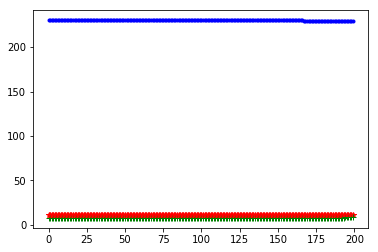

Iteration: 199 Loss: 229.543 Train Accuracy: 10.7857 Test Accuracy: 8.58586


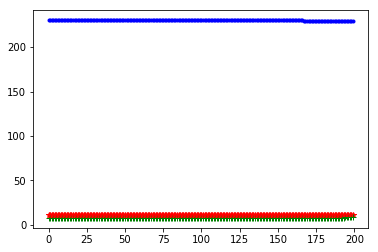

In [16]:
#Iterations to do trainning
for epoch in range(200):
    
    start=0
    end=100
    for i in range(14):
        
        X=X_train[start:end]
        Y=y_train[start:end]
        start=end
        end=start+100
        sess.run(train_step,feed_dict={rnn._inputs:X, y:Y})
    
    Loss=str(sess.run(cross_entropy,feed_dict={rnn._inputs:X, y:Y}))
    Train_accuracy=str(sess.run(accuracy,feed_dict={rnn._inputs:X_train, y:y_train}))
    Test_accuracy=str(sess.run(accuracy,feed_dict={rnn._inputs:X_test, y:y_test}))
    

    pl.plot([epoch],Loss,'b.',)
    pl.plot([epoch],Train_accuracy,'r*',)
    pl.plot([epoch],Test_accuracy,'g+')
    display.clear_output(wait=True)
    display.display(pl.gcf())   
    
    sys.stdout.flush()
    print("\rIteration: %s Loss: %s Train Accuracy: %s Test Accuracy: %s"%(epoch,Loss,Train_accuracy,Test_accuracy)),
    sys.stdout.flush()